# Excited States in Tangelo

Valentin comments:
- we should run the intro by Lee, for example.

## Introduction

One impactful application of quantum chemistry, in both academia or industry, is the study of the interaction of light with matter. Absorption (resp. emission) of a photon by a molecule can promote (resp. demote) an electron from a lower (resp. higher) electronic state to a higher (resp. lower) energy electronic state. The photon wavelength (i.e. energy) required for these transitions to occur is determined by the difference between the two respective electronic states. Therefore, it is imperitive to be able to calculate accurate energies for both ground and excited states to study light/matter interations. These energy differences play a central role in many technologies such as solar panels, light-emitting diodes (LED), displays, and colorants. 

To be more concrete, a colorant must emit light in a narrow region in the visible spectrum to be appropriate for the purpose, that is to say it must exhibit a specific wavelength. Another example is solar panels, where the absorption spectrum of a molecule is tuned (via chemical functionalization) to fit the solar emission spectrum to optimize the energy output efficiency. Here we show an example of a spectrum for the BODIPY molecule, a molecule widely used for fluorescent dyes. BODIPY absorbs light at a lower wavelength (higher energy) and emits light at a higher wavelength (lower energy). To calculate this spectrum, one needs to calculate the ground and excited state energies at multiple nuclear configurations. The absorption spectrum for the simplest BODIPY is shown below. Different absorption and emission wavelengths can be targeted by substituting the hydrogen atoms with different functional groups [J. Chem. Phys. 155, 244102 (2021)](https://aip.scitation.org/doi/10.1063/5.0076787).

![BODIPY](img/bodipy_absorption.png)

As there are an infinite number of compounds, predicting absorption/emission UV-visible spectra would be a valuable asset for the scientific community.

To achieve complete understanding of light interaction with a molecule, the quantum chemistry community has worked on several algorithms. In general, one must compute the relevant molecular electronic structures for the prediction of UV light absorption/emission. This notebook shows how Tangelo enables excited states calculations by featuring a few existing quantum algorithms. These are broadly grouped into variational optimization algorithms and algorithms that rely on Hamiltonian simulation. The use case here is Li $_2$ for computational efficiency but many of these quantum algorithms can, in principle, be extended to much larger systems such as the BODIPY molecule above.

It is worth noting that even with all the computed excited states, non-trivial effects can happen (solvation effect, geometry change, etc.) in which all modify the shape of a spectrum. In this notebook, we do not discuss how these effects are accounted for but the calculations presented here are the necessary first steps towards this Holy Grail.

## Table of Contents

* [1. Obtaining excited state energies classically](#1)
* [2. Variational optimization algorithms](#2)
    * [2.1 VQE for lowest singlet and triplet state ](#21)
    * [2.2 VQE Deflation](#22)
    * [2.3 Quantum Subspace Expansion](#23)
    * [2.4 State-Averaged VQE](#24)
    * [2.5 Multi-state contracted VQE (MC-VQE)](#25)
    * [2.6 State-Averaged VQE with deflation](#26)
    * [2.7 State-Averaged Orbital-Optimized VQE](#27)
* [3. Hamiltonian Simulation algorithms](#3)
    * [3.1 Multi-Reference Selected Quantum Krylov](#31)
    * [3.2 Rodeo Algorithm](#32)
* [4. Closing words](#4)

We start by defining the molecular system. For this notebook we are going to use Li $_2$ near its equilibrium geometry. The full calculation of Li $_2$ would be non-trivial and very computationally expensive. Therefore, we restrict ourselves to an active space of 2 electrons in 2 orbitals. However, there are still non-trivial effects that occur with this small state which is especially evident in section [2.7](#27).  We define two molecule objects with `mol_li2` defined as the ground state configuration with 2 electrons in the HOMO, and `mol_li2_t` defined as the triplet configuration with an alpha electron in each of the HOMO and LUMO.

In [1]:
from tangelo import SecondQuantizedMolecule
li2=  """Li 0. 0. 0.
Li 3.0 0. 0. """

# 2 electrons in 2 orbitals
frozen_orbitals = [0,1]+[i for i in range(4,28)]

# Runs RHF calculation
mol_Li2 = SecondQuantizedMolecule(li2, q=0, spin=0, basis='6-31g(d,p)',
                                   frozen_orbitals=frozen_orbitals, symmetry=True)

# Runs ROHF calculation
mol_Li2_t = SecondQuantizedMolecule(li2, q=0, spin=2, basis="6-31g(d,p)",
                                     frozen_orbitals=frozen_orbitals, symmetry=True)

As we set `symmetry=True` in the initialization. The symmetry labels of all the orbitals have been populated in `mol_li2.mo_symm_labels`. It is easy to output the molecular orbitals to .cube files which can be viewed with your chosen molecular orbital viewer.

In [2]:
# Symmetry labels and occupations for frozen core and active orbitals
print("  #  Energy  Symm Occ")
for i in range(4):
    print(f"{i+1:3d}{mol_Li2.mo_energies[i]: 9.4f}  {mol_Li2.mo_symm_labels[i]}   {int(mol_Li2.mo_occ[i])}")

# Active electrons, Active orbitals
print(f"Number of active electrons: {mol_Li2.n_active_electrons}")
print(f"Number of active orbtials: {mol_Li2.n_active_mos}")

  #  Energy  Symm Occ
  1  -2.4478  A1g   2
  2  -2.4478  A1u   2
  3  -0.1716  A1g   2
  4   0.0129  A1u   0
Number of active electrons: 2
Number of active orbtials: 2


We can examine the molecular orbitals by exporting them as cube files. These can then be read in by your favourite orbital viewer.

```python
from pyscf.tools import cubegen
# Output cube files for active orbitals
for i in [2, 3]:
    cubegen.orbital(mol_Li2.to_pyscf(basis = mol_Li2.basis), f'li2_{i+1}.cube', mol_Li2.mean_field.mo_coeff[:, i])
```

## Obtaining excited state energies classically <a class="anchor" id="1"></a>

In order to compare the various quantum algorithms, it is useful to have the classically calculated values. Below we will calculate the two A1g and A2g states using pyscf.

In [3]:
from pyscf import mcscf

myhf = mol_Li2.mean_field
ncore = {"A1g": 1, "A1u": 1}
ncas = {"A1g": 1, "A1u": 1}

print("Calculation for A1g symmetry")
mc = mcscf.CASCI(myhf, 2, (1, 1))
mo = mc.sort_mo_by_irrep(cas_irrep_nocc=ncas, cas_irrep_ncore=ncore)
mc.fcisolver.wfnsym = "A1g"
mc.fcisolver.nroots = 2
emc_A1g = mc.casci(mo)[0]

print("\n Calculation for A1u symmetry")
mc = mcscf.CASCI(myhf, 2, (1, 1))
mc.fcisolver.wfnsym = "A1u"
mc.fcisolver.nroots = 2
emc_A1u = mc.casci(mo)[0] 

Calculation for A1g symmetry

WARN: Mulitple states found in CASCI solver. First state is used to compute the natural orbitals in active space.

CASCI state 0  E = -14.8696203037798  E(CI) = -0.575225247721381  S^2 = 0.0000000
CASCI state 1  E = -14.6801959955889  E(CI) = -0.385800939530506  S^2 = 0.0000000

 Calculation for A1u symmetry

WARN: Mulitple states found in CASCI solver. First state is used to compute the natural orbitals in active space.

CASCI state 0  E = -14.8387663453704  E(CI) = -0.544371289311979  S^2 = 2.0000000
CASCI state 1  E = -14.784038331423  E(CI) = -0.489643275364569  S^2 = 0.0000000


## 2. Variational algorithms<a class="anchor" id="2"></a>

We start by showing how different approaches based on the Variational Quantum Eigensolver (VQE) can be used to obtain excited states. For more information about VQE and the `VQESolver` class, feel free to have a look at our dedicated tutorials.

### 2.1 VQE for lowest singlet and triplet state <a class="anchor" id="21"></a>

Both the lowest singlet (ground state) and lowest triplet (first excited state) can be computed using `VQESolver`. The `FCISolver` class can be used to produce a classically-computed reference value, to get a sense of the accuracy of VQE in this situation.

In [4]:
from tangelo.algorithms.variational import VQESolver, BuiltInAnsatze
from tangelo.algorithms.classical import FCISolver

# Ground state energy calculation with VQE, reference values with FCI
vqe_options = {"molecule": mol_Li2, "ansatz": BuiltInAnsatze.UCCSD}
vqe_solver = VQESolver(vqe_options)
vqe_solver.build()
vqe_energy = vqe_solver.simulate()
print("\n Ground Singlet state")
print(f"VQE energy = {vqe_energy}")
print(f"CASCI energy = {FCISolver(mol_Li2).simulate()}")

# First excited state energy calculation with VQE, reference values with FCI
vqe_options = {"molecule": mol_Li2_t, "ansatz": BuiltInAnsatze.UpCCGSD}
vqe_solver_t = VQESolver(vqe_options)
vqe_solver_t.build()
vqe_energy_t = vqe_solver_t.simulate()
print("\n Lowest Triplet state")
print(f"VQE energy = {vqe_energy_t}")
print(f"CASCI energy = {FCISolver(mol_Li2_t).simulate()}")


 Ground Singlet state
VQE energy = -14.86962030275721
CASCI energy = -14.869620303779781

 Lowest Triplet state
VQE energy = -14.853462489026873
CASCI energy = -14.853462489027105


### 2.2 VQE Deflation <a class="anchor" id="22"></a>

Deflation can be used to gradually obtain higher and higher excited states, by applying an orthogonality penalty against all previous VQE calculations. This idea was introduced in [arXiv:2205.09203](https://arxiv.org/abs/2205.09203).

This approach can be implented by using the deflation options built in the `VQESolver` class:

- The keyword `"deflation_circuits"` allows the user to provide a list of circuits to use in the deflation process
- Additionally, the keyword `"deflation_coeff"` allows a user to specify the weight in front of the penalty term. This coefficient must be larger than the difference in energy between the ground and excited state.

In [5]:
# Add initial VQE optimal circuit to the deflation circuits list
deflation_circuits = [vqe_solver.optimal_circuit.copy()]

# Calculate first and second excited state by adding optimal circuits to deflation_circuits
for i in range(2):
    vqe_options = {"molecule": mol_Li2, "ansatz": BuiltInAnsatze.UpCCGSD, 
                   "deflation_circuits": deflation_circuits, "deflation_coeff": 0.4}
    vqe_solver = VQESolver(vqe_options)
    vqe_solver.build()
    vqe_energy = vqe_solver.simulate()
    print(f"Excited state #{i+1} \t VQE energy = {vqe_energy}")
    deflation_circuits.append(vqe_solver.optimal_circuit.copy())

Excited state #1 	 VQE energy = -14.784037073787918
Excited state #2 	 VQE energy = -14.680196061798949


The deflation above generated the singlet states. Sometimes it is useful to use a different reference state. In the next example of deflation, we use a reference state with 2 alpha electrons and 0 beta electrons to calculate the triplet state. The reference state is defined by alternating up then down ordering, which yields `{"ref_state": [1, 0, 1, 0]}` for 2 alpha electrons in 2 orbitals for this situation.

In [6]:
vqe_options = {"molecule": mol_Li2, "ansatz": BuiltInAnsatze.UpCCGSD, 
               "deflation_circuits": deflation_circuits,
               "deflation_coeff": 0.4, "ref_state": [1, 0, 1, 0]}
vqe_solver_triplet = VQESolver(vqe_options)
vqe_solver_triplet.build()
vqe_energy = vqe_solver_triplet.simulate()
print(f"VQE energy = {vqe_energy}")

VQE energy = -14.838766345424597


This value is a great match for the triplet CASCI reference values we obtained earlier. We calculated all the excited states calculated using CASCI using deflation by running `VQESolver` 4 times.

The `deflation_circuits` option is also available for the SA-VQE solver shown in another section of this notebook (`SA_VQESolver`), as well as ADAPT (`ADAPTSolver`).

### 2.3 Quantum Subspace Expansion <a class="anchor" id="23"></a>

Another way to obtain excited states is to define a pool of operators providing a good approximation to the excitations needed to represent the excited states from the ground state calculations produced by `VQESolver`. This idea was presented in [arXiv:1603.05681](https://arxiv.org/abs/1603.05681).

For this example, we choose a pool of operators of the form $O_p=a_i^{\dagger}a_j$.

We then have to solve $FU = SUE$, where $F_{pq}=\left<\psi\right|O_p^* H O_q\left|\psi\right>$ and $S_{pq}=\left<\psi\right|O_p^* O_q\left|\psi\right>$.

For simplicity here, we keep all wavefunction symmetry excitations. However, the matrix we need to diagonalize can be made smaller by only keeping excitations that respect the desired wavefunction symmetry of the excited state.

In [7]:
import numpy as np
from scipy.linalg import eigh
from openfermion.utils import hermitian_conjugated
from tangelo.toolboxes.operators import FermionOperator
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping as f2q_mapping

# Generate all single excitations as qubit operators
op_list = list()
for i in range(2):
    for j in range(i+1, 2):
        op_list += [f2q_mapping(FermionOperator(((2*i, 1), (2*j, 0))), "jw")] #spin-up transition
        op_list += [f2q_mapping(FermionOperator(((2*i+1, 1), (2*j+1, 0))), "jw")] #spin-down transition
        op_list += [f2q_mapping(FermionOperator(((2*i+1, 1), (2*j, 0))), "jw")] #spin-up to spin-down
        op_list += [f2q_mapping(FermionOperator(((2*i, 1), (2*j+1, 0))), "jw")] #spin-down to spin-up

# Compute F and S matrices.
size_mat = len(op_list)
h = np.zeros((size_mat, size_mat))
s = np.zeros((size_mat, size_mat))
state_circuit = vqe_solver.optimal_circuit
for i, op1 in enumerate(op_list):
    for j, op2 in enumerate(op_list):
        h[i, j] = vqe_solver.backend.get_expectation_value(hermitian_conjugated(op1)*vqe_solver.qubit_hamiltonian*op2, state_circuit)
        s[i, j] = vqe_solver.backend.get_expectation_value(hermitian_conjugated(op1)*op2, state_circuit)

# Solve FU = SUE
e, v = eigh(h,s)
print(f"Quantum Subspace Expansion energies: \n {e}")

Quantum Subspace Expansion energies: 
 [-14.83876635 -14.83876635 -14.83876635 -14.7840384 ]


We can see that we have obtained the correct energies for CASCI state A1g state 1, and A2 state 0 and 1. A1g state 1 was not recovered. We would therefore need to measure more excitations in $F$.

### 2.4 State-Averaged VQE <a class="anchor" id="24"></a>

Another method to obtain excited states is to use the State-Averaged VQE Solver. It minimizes the average of multiple orthogonal reference states with the same ansatz. As the reference states are orthogonal, using the same circuit will retain it's orthogonality. This idea can be found in [arXiv:2009.11417](https://arxiv.org/pdf/2009.11417.pdf).

Here we are going to target singlet states only. This can be accomplished by adding a penalty term by `"penalty_terms": {"S^2": [2, 0]}`. This means that the target Hamiltonian to be minimized is $H = H_0 + 2 (\hat{S}^2 - 0)^2$ where $H_0$ is the original molecular Hamiltonian.

In [8]:
from tangelo.algorithms.variational import SA_VQESolver, BuiltInAnsatze

vqe_options = {"molecule": mol_Li2, "ref_states": [[1,1,0,0], [1,0,0,1], [0,0,1,1]],
               "weights": [1, 1, 1], "penalty_terms": {"S^2": [2, 0]},
               "qubit_mapping": "jw", "ansatz": BuiltInAnsatze.UpCCGSD, "ansatz_options": {"k": 2}
               }
vqe_solver = SA_VQESolver(vqe_options)
vqe_solver.build()
enernew = vqe_solver.simulate()
for i, energy in enumerate(vqe_solver.state_energies):
    print(f"Singlet State {i} has energy {energy}")

Singlet State 0 has energy -14.742180681561159
Singlet State 1 has energy -14.81212566726279
Singlet State 2 has energy -14.77954006551489


The energies above are not correct as the calculated states are only guaranteed to be a linear combination of the three lowest singlet states. We will need to use MC-VQE below to generate the exact eigenvectors. 

However, as you can see from below, the $\hat{S}^2$ expectation value is nearly zero for all states so they are all singlet as expected when using the penalty term.

In [9]:
from tangelo.toolboxes.ansatz_generator.fermionic_operators import spin2_operator
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping

s2op = fermion_to_qubit_mapping(spin2_operator(2), "jw")
for i in range(3):
    print(f"State {i} has S^2 = {vqe_solver.backend.get_expectation_value(s2op, vqe_solver.reference_circuits[i]+vqe_solver.optimal_circuit)}")


State 0 has S^2 = 3.529238046251493e-08
State 1 has S^2 = 2.022384925304266e-06
State 2 has S^2 = 7.838202087384616e-09


### 2.5 Multistate, contracted VQE (MC-VQE) <a class="anchor" id="25"></a>

To obtain the energies of the individual states, we sometimes need to us multistate, contracted VQE (MC-VQE)[arXiv:1901.01234](https://arxiv.org/abs/1901.01234). This process defines a small matrix by measuring Hamiltonian expectation values of $(\left|\theta_i\right>+\left|\theta_j\right>)/\sqrt{2}$ and $(\left|\theta_i\right>-\left|\theta_j\right>)/\sqrt{2}$ of our states. 

In general, the ref_states are simple occupations so generating $(\left|\theta_i\right>+\left|\theta_j\right>)/\sqrt{2}$ and $(\left|\theta_i\right>-\left|\theta_j\right>)/\sqrt{2}$ by hand "should" be fairly straightforward. For this notebook, we are simply going to let Tangelo obtain these statevectors and then generate the expectation values.

In [10]:
# Generate individual statevectors
ref_svs = list()
for circuit in vqe_solver.reference_circuits:
    _, sv = vqe_solver.backend.simulate(circuit, return_statevector=True)
    ref_svs.append(sv)

# Generate Equation (2) using equation (4) and (5) of arXiv:1901.01234
h_theta_theta = np.zeros((3,3))
for i, sv1 in enumerate(ref_svs):
    for j, sv2 in enumerate(ref_svs):
        if i != j:
            sv_plus = (sv1 + sv2)/np.sqrt(2)
            sv_minus = (sv1 - sv2)/np.sqrt(2)
            exp_plus = vqe_solver.backend.get_expectation_value(vqe_solver.qubit_hamiltonian, vqe_solver.optimal_circuit, initial_statevector=sv_plus)
            exp_minus = vqe_solver.backend.get_expectation_value(vqe_solver.qubit_hamiltonian, vqe_solver.optimal_circuit, initial_statevector=sv_minus)
            h_theta_theta[i, j] = (exp_plus-exp_minus)/2
        else:
            h_theta_theta[i, j] = vqe_solver.state_energies[i]

e, _ = np.linalg.eigh(h_theta_theta)
for i, energy in enumerate(e):
    print(f"Singlet State {i} \t MC-VQE energy = {energy}")

Singlet State 0 	 MC-VQE energy = -14.869616815258514
Singlet State 1 	 MC-VQE energy = -14.784034669940823
Singlet State 2 	 MC-VQE energy = -14.680194929139502


We can see that these singlet energies are all close to the exact answer. 

#### Using StateVector for MC-VQE
The code below can be used obtain the same MC-VQE result by using `StateVector` to automatically generate circuits for $(|\theta_i>+|\theta_j>)/\sqrt{2}$ and $(|\theta_i>-|\theta_j>)/\sqrt{2}$. However, the circuits created by StateVector are generally inefficient and one should try to create the circuits that generate these states by hand if running on a real quantum device.

In [11]:
from tangelo.linq.helpers import StateVector

# Generate individual statevectors
ref_svs = list()
for state in vqe_solver.ref_states:
    sv = np.zeros(2**6)
    # generate bitstring representation of each ref_state and populate that position in the statevector
    bitstring = "".join([str(i) for i in reversed(state)])
    sv[int(bitstring, base=2)] = 1
    ref_svs.append(sv)

# Generate Equation (2) using equation (4) and (5) of arXiv:1901.01234
h_theta_theta = np.zeros((3,3))
for i, sv1 in enumerate(ref_svs):
    for j, sv2 in enumerate(ref_svs):
        if i != j:
            sv_plus = (sv1 + sv2)/np.sqrt(2)
            sv_plus = StateVector(sv_plus)
            ref_circ_plus = sv_plus.initializing_circuit()
            sv_minus = (sv1 - sv2)/np.sqrt(2)
            sv_minus = StateVector(sv_minus)
            ref_circ_minus = sv_minus.initializing_circuit()
            exp_plus = vqe_solver.backend.get_expectation_value(vqe_solver.qubit_hamiltonian, ref_circ_plus + vqe_solver.optimal_circuit)
            exp_minus = vqe_solver.backend.get_expectation_value(vqe_solver.qubit_hamiltonian, ref_circ_minus + vqe_solver.optimal_circuit)
            h_theta_theta[i, j] = (exp_plus-exp_minus)/2
        else:
            h_theta_theta[i, j] = vqe_solver.state_energies[i]

e, _ = np.linalg.eigh(h_theta_theta)
for i, energy in enumerate(e):
    print(f"Singlet State {i} \t MC-VQE energy = {energy}")

Singlet State 0 	 MC-VQE energy = -14.869616815258532
Singlet State 1 	 MC-VQE energy = -14.784034669940802
Singlet State 2 	 MC-VQE energy = -14.680194929139498


### 2.6 State-Averaged VQE with deflation <a class="anchor" id="26"></a>
We can obtain the final excited state by using deflation for the three singlet states above and removing the penalty term. Once again, we define a reference state by `"ref_states": [[1, 0, 1, 0]]` that will better target the remaining triplet state.

In [12]:
vqe_options = {"molecule": mol_Li2, "ref_states": [[1, 0, 1, 0]],
               "weights": [1], "deflation_circuits": [vqe_solver.reference_circuits[i]+vqe_solver.optimal_circuit for i in range(3)],
               "qubit_mapping": "jw", "ansatz": BuiltInAnsatze.UpCCGSD, "ansatz_options": {"k": 2}
               }
vqe_solver_deflate = SA_VQESolver(vqe_options)
vqe_solver_deflate.build()
enernew = vqe_solver_deflate.simulate()
for i, energy in enumerate(vqe_solver_deflate.state_energies):
    print(f"Triplet State {i} has energy {energy}")

Triplet State 0 has energy -14.83876634542459


This is the correct triplet state energy.

### 2.7 State-Averaged Orbital-Optimized VQE <a class="anchor" id="27"></a>

This performs the equivalent of a CASSCF calculation using a quantum computer. There are multiple iterations of the two steps: 1)A SA-VQE calculation followed by 2) An orbital optimization. These iterations are called by using the `iterate()` call. If one called `simulate()` from `SA_OO_Solver`, it would only perform a State-Averated VQE simulation. The reference for this method is [arXiv:2009.11417](https://arxiv.org/pdf/2009.11417.pdf)

In [13]:
from tangelo.algorithms.variational import SA_OO_Solver

In [14]:
mol_Li2_nosym = SecondQuantizedMolecule(li2, q=0, spin=0, basis='6-31g(d,p)',
                                   frozen_orbitals=frozen_orbitals, symmetry=False)
vqe_options = {"molecule": mol_Li2_nosym, "ref_states": [[1,1,0,0], [1,0,1,0]],
               "weights": [1, 1],
               "qubit_mapping": "jw", "ansatz": BuiltInAnsatze.UpCCGSD, "ansatz_options": {"k": 2}
               }
vqe_solver = SA_OO_Solver(vqe_options)
vqe_solver.build()
enernew = vqe_solver.iterate()
for i, energy in enumerate(vqe_solver.state_energies):
    print(f"State {i} has energy {energy}")

State 0 has energy -14.875599348234621
State 1 has energy -14.851789148471193


We can compare the `SA_OO_VQE` solution to CASSCF from pyscf and determine that they obtain the same result.

In [15]:
mol_Li2_no_sym_copy = SecondQuantizedMolecule(li2, q=0, spin=0, basis='6-31g(d,p)',
                                   frozen_orbitals=frozen_orbitals, symmetry=False)
mc = mcscf.CASSCF(mol_Li2_no_sym_copy.mean_field, 2, 2).state_average([0.5, 0.5])
energy = mc.kernel()

CASSCF energy = -14.8636942982906
CASCI E = -14.8636942982906  E(CI) = -0.569133524449605  S^2 = 1.0000000
CASCI state-averaged energy = -14.8636942982906
CASCI energy for each state
  State 0 weight 0.5  E = -14.8756048775827 S^2 = 0.0000000
  State 1 weight 0.5  E = -14.8517837189985 S^2 = 2.0000000


`SA_OO_Solver` has optimized the orbitals in `mol_Li2_nosym` to minimize the average energy of the states above. We can then use the code below to output the optimized molecular orbitals as cube files and compare to the unoptimized orbitals from the top of the notebook.

```python
from pyscf.tools import cubegen
# loop over active orbitals i.e. 2, 3
for i in [2, 3]:
   cubegen.orbital(mol_Li2_nosym.to_pyscf(basis = mol_Li2_nosym.basis), f'li2_{i+1}_opt.cube', mol_Li2_nosym.mean_field.mo_coeff[:, i])
```

Using [Avogadro](https://avogadro.cc/) to generate the two figures below with the .cube files outputted above, we see that the original fourth molecular orbital and the optimized fourth molecular orbital look very different:

<table>
    <tr>
    <td style='text-align:center;'>
        <b> Original molecular orbital </b><img>
    </td>
    <td style='text-align:center;'>
        <b> Optimized molecular orbital</b><img>
    </td>
    </tr>
    <tr>
    <td style='text-align:center;'>
        <img src="img/li2_4.png" width="490"/>
    </td>
    <td style='text-align:center;'>
        <img src="img/li2_4_opt.png" width="490"/>
    </td>
    </tr>
</table>


Li ${_2}$ is a molecule that requires CASSCF type optimization to exihibit the correct qualitative behavior when using a small active space. Below, we run `SA_OO_VQE` for multiple different bond lengths and compare to CASCI. This calculation can take more than one minute, depending on your computer.

In [16]:
sa_oo_eners = list()
casci_eners = list()
xvals = np.array([2, 2.2, 2.5, 3., 3.5, 4., 4.5, 5., 6., 7., 9.])

for r in xvals:
    li2_xyz = [('Li', (0, 0, 0)),('Li', (r, 0, 0))]
    
    # VS I do not understand why we are making a copy here. 
    # Does any of the lines modify the second quantized molecule?
    # Compute reference energy with CASCI
    mol_Li2_nosym_copy = SecondQuantizedMolecule(li2_xyz, q=0, spin=0, basis='6-31g(d,p)',
                                                 frozen_orbitals=frozen_orbitals, symmetry=False)
    mc = mcscf.CASCI(mol_Li2_nosym_copy.mean_field, 2, 2)
    mc.fcisolver.nroots = 2
    mc.verbose = 0
    e = mc.kernel()
    casci_eners.append(e[0])

    # Compute SA-OO-VQE energy
    mol_Li2_nosym = SecondQuantizedMolecule(li2_xyz, q=0, spin=0, basis='6-31g(d,p)',
                                            frozen_orbitals=frozen_orbitals, symmetry=False)
    vqe_options = {"molecule": mol_Li2_nosym, "ref_states": [[1, 1, 0, 0], [1, 0, 1, 0]], "tol": 1.e-3,
                   "ansatz": BuiltInAnsatze.UCCGD, "weights": [1, 1], "n_oo_per_iter": 1}
    vqe_solver = SA_OO_Solver(vqe_options)
    vqe_solver.build()
    enernew = vqe_solver.iterate()
    sa_oo_eners.append(vqe_solver.state_energies)

The plot below shows the resulting potential energy curves, and illustrates the impact of orbital optimization for our use case:

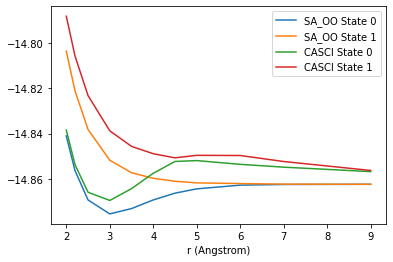

In [17]:
import matplotlib.pyplot as plt

sa_oo_eners=np.array(sa_oo_eners)
casci_eners= np.array(casci_eners)

# VS: TODO, label y axis (quantity, unit)
fig, ax = plt.subplots()
ax.plot(xvals, sa_oo_eners[:, 0], label="SA_OO State 0")
ax.plot(xvals, sa_oo_eners[:, 1], label="SA_OO State 1")
ax.plot(xvals, casci_eners[:, 0], label="CASCI State 0")
ax.plot(xvals, casci_eners[:, 1], label="CASCI State 1")
ax.set_xlabel('r (Angstrom)')
ax.legend()

## 3. Time-dependant algorithms <a class="anchor" id="3"></a>

We now illustrate a few other approches based on time-evolution. Although these algorithms are not NISQ friendly, they do not require non-linear optimization of parameters like VQE-like methods. Therefore, they may have more promise in the fault-tolerant future.

### 3.1 Multi-Reference Selected Quantum Krylov (MRSQK) <a class="anchor" id="31"></a>

A multi-reference selected Quantum Krylov as outlined in [arXiv:1911.05163](https://arxiv.org/abs/1911.05163). This method uses multiple reference states and performs a time evolution $U = e^{-iHt}$ to generate a Krylov representation of the system. The matrix elements are $\cal{H}_{ia,jb} = \left<\phi_a\right|U^i H U^j\left|\phi_b\right>, S_{ia,jb} = \left<\phi_a\right|U^i S U^j\left|\phi_b\right>$ where $\phi_a, \phi_b$ denote different reference configurations. The matrix elements are measured using the procedure outlined in [arXiv:1911.05163](https://arxiv.org/abs/1911.05163) and the energies obtained through solving $\cal{H}V = SVE$.

In [18]:
from itertools import combinations_with_replacement
import numpy as np
from scipy.linalg import eigh

from tangelo.linq import Simulator, Circuit, Gate
from tangelo.toolboxes.operators import QubitOperator
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
from tangelo.toolboxes.qubit_mappings.statevector_mapping import vector_to_circuit
from tangelo.toolboxes.ansatz_generator.ansatz_utils import controlled_pauliwords, trotterize

In [19]:
# Number of Krylov vectors
n_krylov = 4

# Simulation time for each unitary
dt = 1.1

# Qubit Mapping
mapping = "jw"

backend = Simulator()

# Qubit operator for Li2
qu_op =  fermion_to_qubit_mapping(mol_Li2.fermionic_hamiltonian, mapping, mol_Li2.n_active_sos,
                                  mol_Li2.n_active_electrons, up_then_down=False, spin=mol_Li2.spin)

# Operator that measures off-diagonal matrix elements i.e. 2|0><1|
zeroone = (QubitOperator("X4", 1) + QubitOperator("Y4", 1j))

# Controlled unitaries for each term in qu_op
c_qu = controlled_pauliwords(qubit_op=qu_op, control=4, n_qubits=5)

# Controlled time-evolution of qu_op
c_trott = trotterize(qu_op, time=dt, n_trotter_steps=1, trotter_order=1, control=4)

# Generate multiple controlled-reference states.
reference_states = list()
reference_vecs = [[1, 1, 0, 0], [1, 0, 0, 1]]
for vec in reference_vecs:
    circ = vector_to_circuit(vec)
    gates = []
    for gate in circ._gates:
        gates += [Gate("C"+gate.name, target=gate.target, control=4)]
    reference_states += [Circuit(gates)]

# Calculate MRSQK
sab = np.zeros((n_krylov, n_krylov), dtype=complex)
hab = np.zeros((n_krylov, n_krylov), dtype=complex)

for a, b in combinations_with_replacement(range(n_krylov), 2):
    # Generate Ua and Ub unitaries
    ua = reference_states[a%2] + c_trott * (a//2) if a > 1 else reference_states[a%2]
    ub = reference_states[b%2] + c_trott * (b//2) if b > 1 else reference_states[b%2]
    
    # Build circuit from Figure 2 for off-diagonal overlap
    circuit = Circuit([Gate("H", 4)]) + ua + Circuit([Gate("X", 4)]) + ub
    sab[a, b] = backend.get_expectation_value(zeroone, circuit) / 2
    sab[b, a] = sab[a, b].conj()

    # Return statevector for faster calculation of Hamiltonian matrix elements
    _ , initial_state = backend.simulate(circuit, return_statevector=True)
    for i, (term, coeff) in enumerate(qu_op.terms.items()):

        # From calculated statevector append controlled-pauliword for each term in Hamiltonian and measure zeroone
        circuit = c_qu[i]
        expect = coeff*backend.get_expectation_value(zeroone, circuit, initial_statevector=initial_state) / 2
        hab[a, b] += expect
    hab[b, a] = hab[a, b].conj()

e, v = eigh(hab, sab)
print(e)


[-14.8696203  -14.83876635 -14.78403833 -14.680196  ]


The calculated energies are very close to the exact energies calculated at the top of the notebook.

### 3.2 Rodeo Algorithm <a class="anchor" id="32"></a>

Another Hamiltonian simulation based method that can be used to obtain energies is the Rodeo Algorithm. This simulates the Hamiltonian for many random lengths of time with different input energies. The probability of the ancilla qubit being 0 for a given energy $E$ is $P_0(E) = \frac{1 + e^{-\sigma^2 (E_i - E)^2/2}}{2}$ where $E_i$ is one of the eigenvalues of the Hamiltonian. The algorithm is outlined in [arXiv:2110.07747](https://arxiv.org/abs/2110.07747). When the energy $E$ is close to an eigenvalue $E_i$, the probability is maximized. Therefore, we will see peaks in success probability when the input energy $E$ is an eigenvalue.

In [20]:
# One rodeo cycle as defined in Fig.1 of arXiv.2110.07747
def rodeo_cycle(hobj, energy, t, i):
    circuit = Circuit([Gate("H", i)])
    circuit += trotterize(hobj, time=t, control=i, trotter_order=2, n_trotter_steps=40)
    circuit += Circuit([Gate("PHASE", i, parameter=energy*t), Gate("H", i)])
    return circuit

In [21]:
from tangelo.toolboxes.qubit_mappings.statevector_mapping import do_scbk_transform

h_obj =  fermion_to_qubit_mapping(mol_Li2.fermionic_hamiltonian, "scbk", mol_Li2.n_active_sos,
                                  mol_Li2.n_active_electrons, up_then_down=True, spin=mol_Li2.spin)

# Stretch factor of 300 to make eigenvalue gap larger. Therefore, time evolution needs to be shorter.
h_obj = 300*(h_obj - QubitOperator((), -14.85))

sim = Simulator()

sigma = 0.4

# We will use multiple reference states as probability depends on overlap with starting state.
ref_states = [vector_to_circuit(do_scbk_transform([1, 1, 0, 0], 4)),
              vector_to_circuit(do_scbk_transform([1, 0, 1, 0], 4)),
              vector_to_circuit(do_scbk_transform([0, 0, 1, 1], 4))]

# Equivalent to energies from -14.9 -> 14.75
energies = [-0.05*300 +300*0.005*i for i in range(30)]
success_prob = list()
for energy in energies:
    success=0
    for sample in range(20):
        t = np.random.normal(0, sigma, 1)
        circuit = np.random.choice(ref_states)
        for i, tk in enumerate(t):
            circuit += rodeo_cycle(h_obj, energy, tk, i+2)
        f, _ = sim.simulate(circuit)
        for key, v in f.items():
            if key[2:] == "0":
                success += v
    success_prob.append(success/20)

Text(0, 0.5, 'Success Probability')

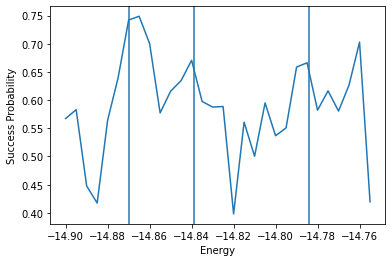

In [22]:
fig, ax = plt.subplots()
evals = [-14.8696203,  -14.83876635, -14.78403833]
for e in evals:
    ax.axvline(x=e) # VS: I suggest 'color'='red', 'linestyle'='--'
ax.plot(np.array(energies)/300-14.85, success_prob)
ax.set_xlabel('Energy')
ax.set_ylabel('Success Probability')

The above plot shows promise that the correct energies are peaks in the success probability. To save time, below is the result after running the above code for 1000 iterations. The peaks are centered on the exact energies, represented by the vertical bars.

<img align="left" width="400" src="img/rodeo_1000.png" />

## 4. Closing words <a class="anchor" id="4"></a>

- Resource estimation for a relevant active space for BODIPY (to search in the litt.)
- Encourage users to work on excited states: selection of the active space is very important.

This notebook has shown that there are many different algorithms that can be used to calculate excited states in Tangelo. Unlike ground states, the use of variational methods requires either penalizing against previously calculated states or the optimization of a collection of orthogonal states. Outside of variational methods, we have shown two time-evolution based algorithms that can be used to calculate excited states.

Although we did examine many interesting techniques, we can now return to BODIPY to exemplify the magnitude of the work that needs to be done.

In [25]:
bodipy = SecondQuantizedMolecule("data/bodipy.xyz", q=0, spin=0, basis="sto-3g")
print(f"Active electrons = {bodipy.n_active_mos}")
print(f"Active orbitals = {bodipy.n_active_electrons}")

Active electrons = 63
Active orbitals = 70


Whereas we did a calculation with 2 electrons in 2 orbitals, the full calculation of BODIPY would be 63 electrons in 70 orbitals with the core electrons frozen. The number of qubits needed to represent this would be 140 for the Jordan-Wigner mapping compared to the 4 qubits used in this notebook. J. Chem. Theory. Comput. 2015Therefore, there is still much work to be done to efficiently calculate excited states using quantum computers.